In [1]:
import bilby
import numpy as np

import bilby.core.likelihood.simulation_based_inference as sbibilby
from bilby.core.likelihood.simulation_based_inference import GenerateData
import matplotlib.pyplot as plt

In [11]:
class GenerateWhitenedIFONoise(GenerateData):
    """
    TBD
    Parameters
    ==========
    num_data:
    """

    def __init__(self, ifo):
        super(GenerateWhitenedIFONoise, self).__init__(
            parameters=dict(sigma=None),
            call_parameter_key_list=["sigma"],
        )
        self.ifo = ifo

    def get_data(self, parameters: dict):
        self.parameters.update(parameters)
        sigma = self.parameters["sigma"]
        self.ifo.set_strain_data_from_power_spectral_density(
            sampling_frequency=self.ifo.sampling_frequency,
            duration=self.ifo.duration,
            start_time=self.ifo.start_time,
        )
        window_start = self.ifo.start_time + 1.5
        window_end = self.ifo.start_time + 2.2
        mask = (self.ifo.time_array >= window_start) & (self.ifo.time_array <= window_end)
        whitened_strain = self.ifo.whitened_time_domain_strain * np.array(sigma)
        whitened_strain=whitened_strain[mask]
        return whitened_strain


class GenerateWhitenedSignal(GenerateData):
    """
    TBD

    Parameters
    ==========
    ifo:

    waveform_generator:

    bilby_prior:
    """

    def __init__(self, ifo, waveform_generator, signal_prior):
        call_parameter_key_list = signal_prior.non_fixed_keys
        parameters = signal_prior.sample()

        super(GenerateWhitenedSignal, self).__init__(
            parameters=parameters,
            call_parameter_key_list=call_parameter_key_list,
        )
        self.ifo = ifo
        self.waveform_generator = waveform_generator

    def get_data(self, parameters: dict):
        self.parameters.update(parameters)
        parameters = self.parameters

        # Simulate the GW signal
        waveform_polarizations = waveform_generator.time_domain_strain(parameters)
        signal = {}
        for mode in waveform_polarizations.keys():
            det_response = self.ifo.antenna_response(
                parameters['ra'],
                parameters['dec'],
                parameters['geocent_time'],
                parameters['psi'], mode)
            signal[mode] = waveform_polarizations[mode] * det_response
        ht = sum(signal.values())

        # Correct the time
        time_shift = self.ifo.time_delay_from_geocenter(
            parameters['ra'], parameters['dec'], parameters['geocent_time'])
        dt_geocent = parameters['geocent_time'] - self.ifo.strain_data.start_time
        dt = dt_geocent + time_shift
        nroll = int(dt * self.ifo.sampling_frequency)
        ht = np.roll(ht, nroll)

        # Whiten the time-domain signal
        hf = np.fft.rfft(ht)
        ht_tilde = np.fft.irfft(hf / (self.ifo.amplitude_spectral_density_array * np.sqrt(self.ifo.duration / 4)))
        #Taking only the piece necessary for the training
        window_start = self.ifo.start_time + 1.5
        window_end = self.ifo.start_time + 2.2
        mask = (self.ifo.time_array >= window_start) & (self.ifo.time_array <= window_end)
        ht_tilde=ht_tilde[mask]
        return ht_tilde

In [12]:
injection_parameters = dict(
    mass_1=36.0,
    mass_2=29.0,
    a_1=0.4,
    a_2=0.3,
    tilt_1=0.5,
    tilt_2=1.0,
    phi_12=1.7,
    phi_jl=0.3,
    luminosity_distance=1000.0,
    theta_jn=0.4,
    psi=2.659,
    phase=1.3,
    geocent_time=1126259642.413,
    ra=1.375,
    dec=-1.2108,
)

#injection_parameters['sigma'] = 1

signal_priors = bilby.gw.prior.BBHPriorDict()
for key in [
    "a_1",
    "a_2",
    "tilt_1",
    "tilt_2",
    "phi_12",
    "phi_jl",
    "psi",
    "ra",
    "dec",
    "geocent_time",
    "phase",
    "luminosity_distance",
    "theta_jn"
]:
    signal_priors[key] = injection_parameters[key]
signal_priors['mass_ratio']=29.0/36.0
noise_priors = bilby.core.prior.PriorDict(dict(sigma=bilby.core.prior.Uniform(0, 2, 'sigma')))

duration = 4.0
sampling_frequency = 1024.0
minimum_frequency = 20
trigger = 1126259642.4
start_time = trigger - duration / 2

waveform_arguments = dict(
    waveform_approximant="IMRPhenomPv2",
    reference_frequency=50.0,
    minimum_frequency=minimum_frequency,
)

# Create the waveform_generator using a LAL BinaryBlackHole source function
waveform_generator = bilby.gw.WaveformGenerator(
    duration=duration,
    sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=waveform_arguments,
)

outdir = "outdir_1"
label = "TEST_1"

ifos = bilby.gw.detector.InterferometerList(['H1'])
ifos.set_strain_data_from_power_spectral_densities(
    sampling_frequency=sampling_frequency,
    duration=duration,
    start_time=start_time,
)
ifos.inject_signal(
    waveform_generator=waveform_generator, parameters=injection_parameters
)
ifo = ifos[0]

14:37 bilby INFO    : No prior given, using default BBH priors in /home/mattia.emma/.conda/envs/sbi/lib/python3.10/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.
14:37 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
14:37 bilby INFO    : Injected signal in H1:
14:37 bilby INFO    :   optimal SNR = 23.56
14:37 bilby INFO    :   matched filter SNR = 24.51-1.03j
14:37 bilby INFO    :   mass_1 = 36.0
14:37 bilby INFO    :   mass_2 = 29.0
14:37 bilby INFO    :   a_1 = 0.4
14:37 bilby INFO    :   a_2 = 0.3
14:37 bilby INFO    :   tilt_1 = 0.5
14:37 bilby INFO    :   tilt_2 = 1.0
14:37 bilby INFO    :   phi_12 = 1.7
14:37 bilby INFO    :   phi_jl = 0.3
14:37 bilby INFO    :   luminosity_distance = 1000.0
14:37 bilby INFO    :   theta_jn = 0.4
14:37 bilby INFO    :   psi = 2.659
14:37 bi

1126259640.4 1126259640.4009767 1126259640.4019532
4096


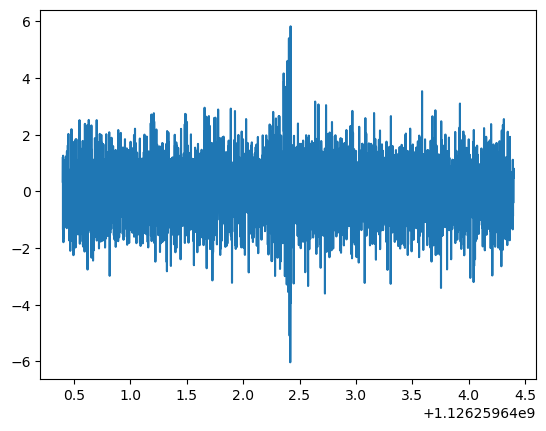

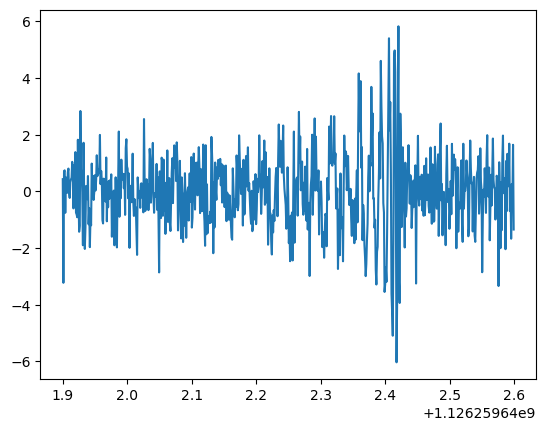

In [13]:
fig, ax = plt.subplots()
yobs = ifo.whitened_time_domain_strain
xobs = ifo.time_array
print(xobs[0], xobs[1], xobs[2])
print(len(xobs))
trigger_time = 1126259642.4
window_start = trigger_time - 0.5
window_end = trigger_time + 0.2

# Create mask to select data within the desired window
mask = (xobs >= window_start) & (xobs <= window_end)

# Slice time and data arrays
cut_time = xobs[mask]
cut_data = yobs[mask]

plt.plot(xobs, yobs)
#ax.set(xlim=(trigger - 0.2, trigger + 0.1))
#ax.set(xlim=(trigger - 0.5, trigger + 0.5))
plt.show()

plt.plot(cut_time, cut_data)
plt.show()

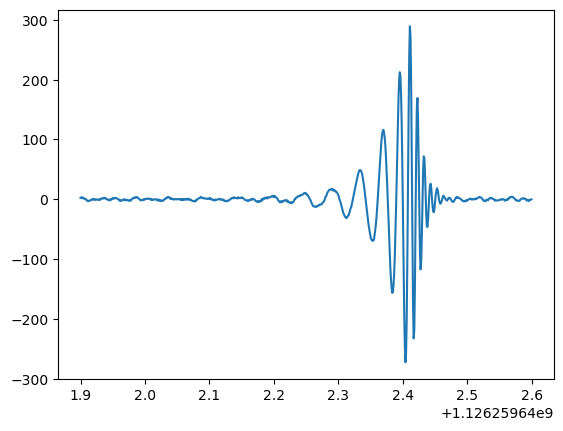

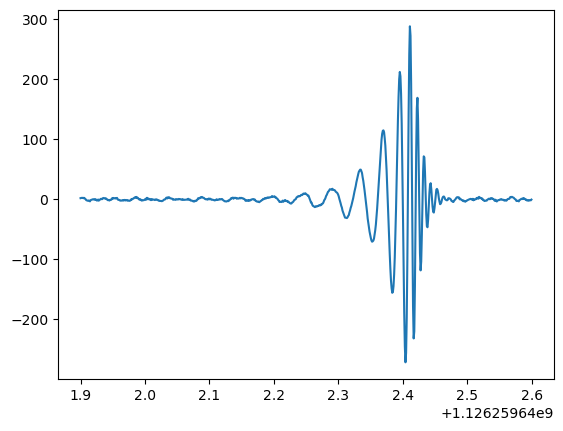

In [15]:
noise = GenerateWhitenedIFONoise(ifo)
signal = GenerateWhitenedSignal(ifo, waveform_generator, signal_priors)
signal_and_noise = sbibilby.AdditiveSignalAndNoise(signal, noise)

priors = noise_priors | signal_priors
priors = bilby.core.prior.PriorDict(priors)
priors.convert_floats_to_delta_functions()
sample = priors.sample()
signal_and_noise.get_data(sample)
plt.plot(cut_time,signal_and_noise.get_data(sample))
plt.show()
cut_signal=signal_and_noise.get_data(sample)
plt.plot(cut_time, cut_signal)
plt.show()

In [17]:
likelihood = sbibilby.NLELikelihood(cut_data, signal_and_noise, priors, label, show_progress_bar=True, num_simulations=2000)
likelihood.init()

14:45 bilby INFO    : Initialise the SBI prior
14:45 bilby INFO    : Initialise the SBI simulator
14:45 bilby INFO    : Initialise training


Running 2000 simulations.:   0%|          | 0/2000 [00:00<?, ?it/s]

 Neural network successfully converged after 446 epochs.

14:59 bilby INFO    : Writing the cached NLE to likelihood_cache/TEST_1_2000.pkl


In [10]:
result = bilby.run_sampler(
    likelihood=likelihood,
    priors=priors,
    sampler="dynesty",
    npoints=250,
    injection_parameters=injection_parameters,
    outdir=outdir,
    label=label,
    check_point_delta_t=60,
    #conversion_function=bilby.gw.conversion.generate_all_bbh_parameters,
)

17:38 bilby INFO    : Running for label 'TEST', output will be saved to 'outdir'
17:38 bilby INFO    : Analysis priors:
17:38 bilby INFO    : sigma=Uniform(minimum=0, maximum=2, name='sigma', latex_label='sigma', unit=None, boundary=None)
17:38 bilby INFO    : chirp_mass=bilby.gw.prior.UniformInComponentsChirpMass(minimum=25, maximum=100, name='chirp_mass', latex_label='$\\mathcal{M}$', unit=None, boundary=None)
17:38 bilby INFO    : mass_1=Constraint(minimum=5, maximum=100, name='mass_1', latex_label='$m_1$', unit=None)
17:38 bilby INFO    : mass_2=Constraint(minimum=5, maximum=100, name='mass_2', latex_label='$m_2$', unit=None)
17:38 bilby INFO    : mass_ratio=0.8055555555555556
17:38 bilby INFO    : luminosity_distance=1000.0
17:38 bilby INFO    : dec=-1.2108
17:38 bilby INFO    : ra=1.375
17:38 bilby INFO    : theta_jn=0.4
17:38 bilby INFO    : psi=2.659
17:38 bilby INFO    : phase=1.3
17:38 bilby INFO    : a_1=0.4
17:38 bilby INFO    : a_2=0.3
17:38 bilby INFO    : tilt_1=0.5
17:3

1it [00:00, ?it/s]

17:40 bilby INFO    : Written checkpoint file outdir/TEST_resume.pickle
/home/mattia.emma/.conda/envs/sbi/lib/python3.10/site-packages/dynesty/plotting.py:318: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axes[i].set_ylim([ymin, ymax])
17:41 bilby INFO    : Written checkpoint file outdir/TEST_resume.pickle
/home/mattia.emma/.conda/envs/sbi/lib/python3.10/site-packages/dynesty/plotting.py:318: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axes[i].set_ylim([ymin, ymax])
17:42 bilby INFO    : Written checkpoint file outdir/TEST_resume.pickle
/home/mattia.emma/.conda/envs/sbi/lib/python3.10/site-packages/dynesty/plotting.py:318: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axes[i].set_ylim([ymin, ymax])
17:43 bilby INFO    : Written checkpoint file outdir/TEST_resume.pickle
/

17:53 bilby INFO    : Summary of results:
nsamples: 625
ln_noise_evidence:    nan
ln_evidence: -7889.117 +/-  0.227
ln_bayes_factor:    nan +/-  0.227



In [12]:
result=bilby.core.result.read_in_result(filename='outdir/TEST_result.json')
print(result.parameter_labels)

['sigma', '$\\mathcal{M}$']


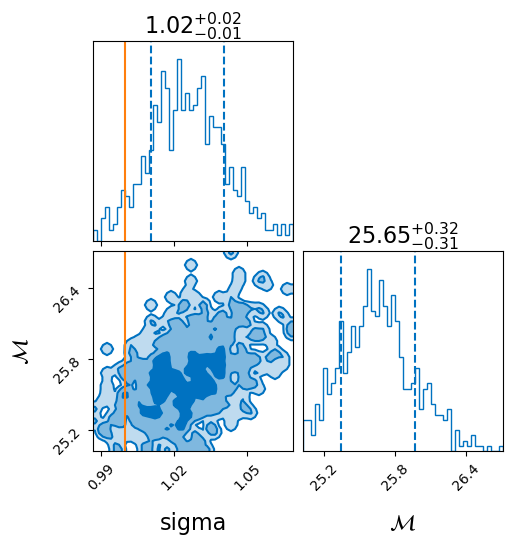

In [17]:
truths = {'sigma':1.0,'chirp_mass':28.1}
result.plot_corner(truths=truths)